# Deep Learning
## Feedforward neural networks - Numpy Implementation

Author: Bingchen Wang

Last Updated: 3 Nov, 2022

---
<nav>
    <a href="../../Machine%20Learning.ipynb">Machine Learning</a> |
    <a href="../../Supervised Learning/Supervised%20Learning.ipynb">Supervised Learning</a> |
    <a href="../Deep Learning Basics.ipynb">Deep Learning</a>
</nav>

---

Aim: Building a neural network from scratch.

## Contents
- [Load packages](#LP)
- [Initialization](#Ini)
- [Forward propagation](#FP)
- [Backpropagation](#BP)
- [Update](#Upd)
- [Train](#Tr)
- [L2 regularization](#L2)
- [Dropout](#Drop)

<a name = "LP"></a>
## Load packages

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [245]:
breast_cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, test_size=0.33, random_state=1)
X = X_train.transpose()
y = y_train.reshape(-1,1).transpose()
feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names

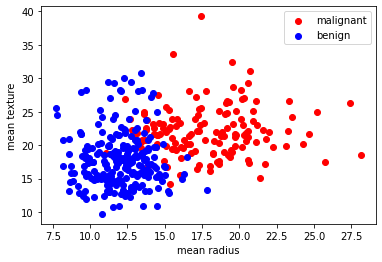

In [246]:
plt.scatter(X[0,y.reshape(-1)==0], X[1,y.reshape(-1)==0], color = 'red', label = target_names[0])
plt.scatter(X[0,y.reshape(-1)==1], X[1,y.reshape(-1)==1], color = 'blue', label = target_names[1])
plt.legend()
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()

<a name = "Ini"></a>
## Initialization

In [28]:
def initialization_W(shape, method = 'he'):
    if method == "he":
        return np.random.randn(*shape) * np.sqrt(2/shape[1])
    if method == "xavier":
        return np.random.randn(*shape) * np.sqrt(1/shape[1])
    if method == "xavier_harmonic":
        return np.random.randn(*shape) * np.sqrt(2/(shape[0] + shape[1]))

def initialization(input_shape, units, method = 'he', verbose = False):
    n,m = input_shape
    parameters = {}
    parameters['W1'] = initialization_W((units[0],n), method)
    parameters['b1'] = np.zeros((units[0],1))
    for i in range(1,len(units)):
        parameters[f'W{i+1}'] = initialization_W((units[i],units[i-1]), method)
        parameters[f'b{i+1}'] = np.zeros((units[i],1))
    print(f'Initialization done. (n_layers = {len(units)})')
    if verbose:
        for item in list(parameters.items()):
            print(f'{item[0]}: {item[1].shape}')
    return parameters

In [30]:
parameters = initialization((10,20), [128, 64, 64, 1], 'he')

Initialization done. (n_layers = 4)
W1: (128, 10)
b1: (128, 1)
W2: (64, 128)
b2: (64, 1)
W3: (64, 64)
b3: (64, 1)
W4: (1, 64)
b4: (1, 1)


<a name = "FP"></a>
## Forward propagation

In [47]:
def layer(a_prev, W, b, activation = 'linear'):
    z = np.matmul(W, a_prev) + b
    if activation == 'linear':
        a = z
    if activation == 'sigmoid':
        a = 1/(1+np.exp(-z))
    if activation == 'tanh':
        a = (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
    if activation == 'ReLU':
        a = np.where(z > 0, z, 0)
    if activation == 'Leaky':
        a = np.where(z > 0.01*z, z, 0.01*z)
    return z, a
        
def forward_propagation(X, parameters, activations, n_layers = None):
    if n_layers is None:
        n_layers = len(parameters)//2
    layer_outputs = {}
    layer_outputs['a0'] = X
    z,a = layer(X, parameters['W1'], parameters['b1'], activations[0])
    layer_outputs['z1'] = z
    layer_outputs['a1'] = a
    for l in range(1,n_layers):
        z,a = layer(a, parameters[f'W{l+1}'], parameters[f'b{l+1}'], activations[l])
        layer_outputs[f'z{l+1}'] = z
        layer_outputs[f'a{l+1}'] = a  
    return a, layer_outputs

In [53]:
X = np.random.randn(10,20)
a, layer_outputs = forward_propagation(X, parameters, activations = ['ReLU','Leaky','tanh','sigmoid'], n_layers = None)

In [147]:
def compute_cost(y_pred, y, method = 'binaryCrossEntropy', err = 1.0e-10):
    _, m = y.shape
    if method == 'binaryCrossEntropy':
        cost = - 1/m * np.sum(y*np.log(y_pred + err) + (1-y)*np.log(1-y_pred))
    if method == 'MSE':
        cost = 1/m * np.sum((y_pred - y)**2)
    return cost

In [45]:
compute_cost(np.random.rand(1,10),np.random.randn(1,10)>0)

0.18378172798694667

<a name = "BP"></a>
## Backpropagation

In [115]:
def back_layer(dz_next,layer_cache, activation):
    a_prev, a, z, W_next = layer_cache
    _, m = a.shape
    da = np.matmul(W_next.transpose(), dz_next)
    if activation == 'linear':
        dz = da
    if activation == 'sigmoid':
        dz = a*(1-a)* da
    if activation == 'tanh':
        dz = (1-a**2)* da
    if activation == 'ReLU':
        dz = np.where(z > 0, 1, 0) * da
    if activation == 'Leaky':
        dz = np.where(z > 0.01*z, 1, 0.01) * da
    dW = 1/m* np.matmul(dz, a_prev.transpose())
    db = 1/m* np.sum(dz, axis = 1, keepdims = True)
    return da, dz, dW, db
def back_propagation(y, parameters, layer_outputs, activations, n_layers = None):
    if n_layers is None:
        n_layers = len(parameters)//2
    gradients = {}
    # Currently only works for cross entropy
    dz = layer_outputs[f'a{n_layers}'] - y
    _, m = y.shape
    gradients[f'dz{n_layers}'] = dz
    gradients[f'dW{n_layers}'] = 1/m* np.matmul(dz, layer_outputs[f'a{n_layers - 1}'].transpose())
    gradients[f'db{n_layers}'] = 1/m* np.sum(dz, axis = 1, keepdims = True)
    
    for l in reversed(range(1, n_layers)):
        layer_cache = (layer_outputs[f'a{l-1}'],layer_outputs[f'a{l}'], layer_outputs[f'z{l}'], parameters[f'W{l+1}'])
        da, dz, dW, db = back_layer(dz, layer_cache, activation = activations[l-1])
        gradients[f'da{l}'],gradients[f'dz{l}'],gradients[f'dW{l}'], gradients[f'db{l}']= da, dz, dW, db
    return gradients

In [62]:
y = (np.random.rand(1,20) > 0.5).astype(int)
gradients = back_propagation(y, parameters, layer_outputs, activations = ['ReLU','Leaky','tanh','sigmoid'], n_layers = None)

<a name = "Upd"></a>
## Update

In [295]:
def update_GD(parameters, gradients, learning_rate = 0.01, lambda_ = 0):
    for para in parameters.keys():
        parameters[para] = (1-learning_rate * lambda_) * parameters.get(para) - learning_rate * gradients.get(f'd{para}')
    return parameters

<a name = "Tr"></a>
## Train

In [319]:
def training(X,y, model_structure, init_method = 'he', n_epochs = 300, learning_rate =0.01, verbose = False, lambda_ = 0):
    cost_history = []
    units, activations = model_structure
    #initialize the parameters
    parameters = initialization(X.shape, units, method = init_method, verbose = False)
    for epoch in range(n_epochs):
        #forward propagation
        y_pred, layer_outputs = forward_propagation(X, parameters, activations, n_layers = len(activations))
        #compute cost
        cost = compute_cost(y_pred, y, method = 'binaryCrossEntropy')
        if lambda_ != 0:
            cost += lambda_/2 * np.sum([np.sum(value**2) for key, value in parameters.items() if key.startswith('W')])
        cost_history.append(cost)
        print(f'\r Current epoch: {epoch+1}/{n_epochs} | Training cost: {cost}', end = "")
        if (epoch+1)%(n_epochs//10) == 0:
            print(f'\r Current epoch: {epoch+1}/{n_epochs} | Training cost: {cost}')
        #backpropagation
        gradients = back_propagation(y, parameters, layer_outputs, activations, n_layers = len(activations))
        #update parameters using batch gradient descent (with learning rate decay)
        if (epoch+1)%(n_epochs//10) == 0:
            learning_rate *= 0.9
        parameters = update_GD(parameters, gradients, learning_rate, lambda_)
    return parameters, cost_history   

In [336]:
def predict(X, model_structure, parameters):
    if len(model_structure) == 2:
        units, activations = model_structure
    if len(model_structure) == 3:
        units, activations, _ = model_structure
    y_pred, _ = forward_propagation(X, parameters, activations, n_layers = len(activations))
    return y_pred

In [298]:
np.random.seed(1)
model1 = ([32,32,16,8,4,1],['ReLU','ReLU','ReLU','ReLU','ReLU','sigmoid'])
parameters, cost_history = training(X[:2,:],y, model1, n_epochs = 20000, learning_rate = 0.005)

Initialization done. (n_layers = 6)
 Current epoch: 2000/20000 | Training cost: 0.5758079080617523
 Current epoch: 4000/20000 | Training cost: 0.5142554248136834
 Current epoch: 6000/20000 | Training cost: 0.45447743136890023
 Current epoch: 8000/20000 | Training cost: 0.39938999862672844
 Current epoch: 10000/20000 | Training cost: 0.33730090633777077
 Current epoch: 12000/20000 | Training cost: 0.30068497877064074
 Current epoch: 14000/20000 | Training cost: 0.27999345140524574
 Current epoch: 16000/20000 | Training cost: 0.24797402596348458
 Current epoch: 18000/20000 | Training cost: 0.23816749782028457
 Current epoch: 20000/20000 | Training cost: 0.22411826083381245


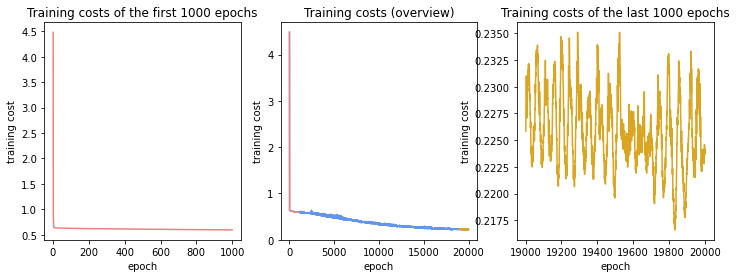

In [299]:
fig, ax = plt.subplots(1,3, figsize = (12,4))
ax[0].plot(range(1,len(cost_history)+1)[:1000], cost_history[:1000], color = "lightcoral")
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training cost')
ax[0].set_title('Training costs of the first 1000 epochs')
ax[1].plot(range(1,len(cost_history)+1), cost_history, color = "cornflowerblue")
ax[1].plot(range(1,len(cost_history)+1)[:1000], cost_history[:1000], color = "lightcoral")
ax[1].plot(range(1,len(cost_history)+1)[-1000:], cost_history[-1000:], color = "goldenrod")
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('training cost')
ax[1].set_title('Training costs (overview)')
ax[2].plot(range(1,len(cost_history)+1)[-1000:], cost_history[-1000:], color = "goldenrod")
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('training cost')
ax[2].set_title('Training costs of the last 1000 epochs')
plt.show()

In [300]:
train_acc = np.mean((predict(X[:2,:], model1, parameters)>0.5) == y)
test_acc = np.mean((predict(X_test.transpose()[:2,:], model1, parameters)>0.5) == y_test.reshape(1,-1))
print(f'Training set accuracy: {round(train_acc,3)} | Test set accuracy: {round(test_acc,3)}')

Training set accuracy: 0.913 | Test set accuracy: 0.872


In [292]:
X1_min, X2_min = np.min(breast_cancer.data[:,:2], axis = 0)
X1_max, X2_max = np.max(breast_cancer.data[:,:2], axis = 0)
X1_span = np.linspace(X1_min, X1_max, 50)
X2_span = np.linspace(X2_min, X2_max, 50)
X1_space, X2_space = np.meshgrid(X1_span, X2_span)
#X_space = np.vstack((X_space[0].reshape(-1),X_space[1].reshape(-1))).transpose()
#leaves_space = tree1.apply(X_space)
#fit_space = tree1.predict(X_space)

fit_space = np.zeros(X1_space.shape)
d1, d2 = fit_space.shape
for i in range(d1):
    for j in range(d2):
        fit_space[i,j] = predict(np.array([[X1_space[i,j]],[X2_space[i,j]]]), model1, parameters)

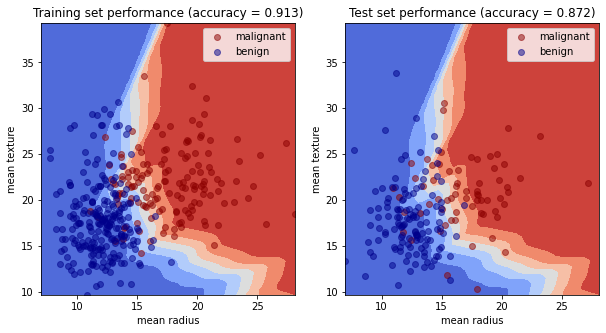

In [293]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[0].scatter(X[0,y.reshape(-1)==0], X[1,y.reshape(-1)==0], color = 'darkred', label = target_names[0], alpha = 0.5)
ax[0].scatter(X[0,y.reshape(-1)==1], X[1,y.reshape(-1)==1], color = 'darkblue', label = target_names[1], alpha = 0.5)
ax[0].legend()
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title(f'Training set performance (accuracy = {round(train_acc,3)})')


ax[1].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[1].scatter(X_test.transpose()[0,y_test==0], X_test.transpose()[1,y_test.reshape(-1)==0], color = 'darkred', label = target_names[0], alpha = 0.5)
ax[1].scatter(X_test.transpose()[0,y_test==1], X_test.transpose()[1,y_test.reshape(-1)==1], color = 'darkblue', label = target_names[1], alpha = 0.5)
ax[1].legend()
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title(f'Test set performance (accuracy = {round(test_acc,3)})')

plt.show()

<a name = "L2"></a>
## L2 Regularization

In [320]:
np.random.seed(1)
model1 = ([32,32,16,8,4,1],['ReLU','ReLU','ReLU','ReLU','ReLU','sigmoid'])
parameters, cost_history = training(X[:2,:],y, model1, n_epochs = 20000, learning_rate = 0.005, lambda_ = 0.05)

Initialization done. (n_layers = 6)
 Current epoch: 2000/20000 | Training cost: 2.2731294451341752
 Current epoch: 4000/20000 | Training cost: 1.2717512872779073
 Current epoch: 6000/20000 | Training cost: 0.8881451605336728
 Current epoch: 8000/20000 | Training cost: 0.7166342168710326
 Current epoch: 10000/20000 | Training cost: 0.6295934957978966
 Current epoch: 12000/20000 | Training cost: 0.5826500553870213
 Current epoch: 14000/20000 | Training cost: 0.5564533771488017
 Current epoch: 16000/20000 | Training cost: 0.5414865302198423
 Current epoch: 18000/20000 | Training cost: 0.5326281097881955
 Current epoch: 20000/20000 | Training cost: 0.5272407777889858


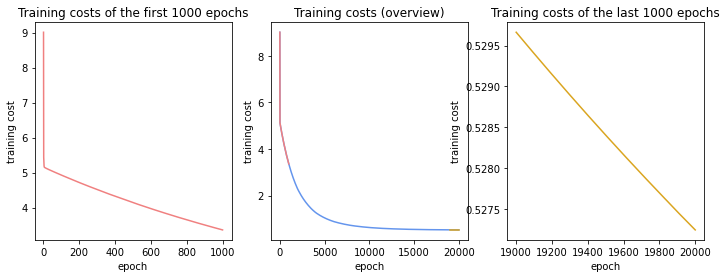

In [321]:
fig, ax = plt.subplots(1,3, figsize = (12,4))
ax[0].plot(range(1,len(cost_history)+1)[:1000], cost_history[:1000], color = "lightcoral")
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training cost')
ax[0].set_title('Training costs of the first 1000 epochs')
ax[1].plot(range(1,len(cost_history)+1), cost_history, color = "cornflowerblue")
ax[1].plot(range(1,len(cost_history)+1)[:1000], cost_history[:1000], color = "lightcoral")
ax[1].plot(range(1,len(cost_history)+1)[-1000:], cost_history[-1000:], color = "goldenrod")
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('training cost')
ax[1].set_title('Training costs (overview)')
ax[2].plot(range(1,len(cost_history)+1)[-1000:], cost_history[-1000:], color = "goldenrod")
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('training cost')
ax[2].set_title('Training costs of the last 1000 epochs')
plt.show()

In [322]:
train_acc = np.mean((predict(X[:2,:], model1, parameters)>0.5) == y)
test_acc = np.mean((predict(X_test.transpose()[:2,:], model1, parameters)>0.5) == y_test.reshape(1,-1))
print(f'Training set accuracy: {round(train_acc,3)} | Test set accuracy: {round(test_acc,3)}')

Training set accuracy: 0.903 | Test set accuracy: 0.888


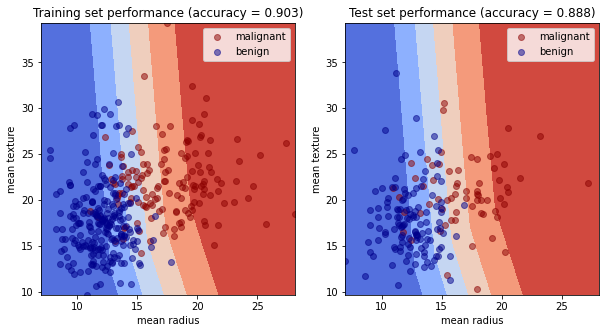

In [323]:
X1_min, X2_min = np.min(breast_cancer.data[:,:2], axis = 0)
X1_max, X2_max = np.max(breast_cancer.data[:,:2], axis = 0)
X1_span = np.linspace(X1_min, X1_max, 50)
X2_span = np.linspace(X2_min, X2_max, 50)
X1_space, X2_space = np.meshgrid(X1_span, X2_span)
#X_space = np.vstack((X_space[0].reshape(-1),X_space[1].reshape(-1))).transpose()
#leaves_space = tree1.apply(X_space)
#fit_space = tree1.predict(X_space)

fit_space = np.zeros(X1_space.shape)
d1, d2 = fit_space.shape
for i in range(d1):
    for j in range(d2):
        fit_space[i,j] = predict(np.array([[X1_space[i,j]],[X2_space[i,j]]]), model1, parameters)
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[0].scatter(X[0,y.reshape(-1)==0], X[1,y.reshape(-1)==0], color = 'darkred', label = target_names[0], alpha = 0.5)
ax[0].scatter(X[0,y.reshape(-1)==1], X[1,y.reshape(-1)==1], color = 'darkblue', label = target_names[1], alpha = 0.5)
ax[0].legend()
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title(f'Training set performance (accuracy = {round(train_acc,3)})')


ax[1].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[1].scatter(X_test.transpose()[0,y_test==0], X_test.transpose()[1,y_test.reshape(-1)==0], color = 'darkred', label = target_names[0], alpha = 0.5)
ax[1].scatter(X_test.transpose()[0,y_test==1], X_test.transpose()[1,y_test.reshape(-1)==1], color = 'darkblue', label = target_names[1], alpha = 0.5)
ax[1].legend()
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title(f'Test set performance (accuracy = {round(test_acc,3)})')

plt.show()

<a name = "Drop"></a>
## Dropout

In [331]:
def layer_dropout(a_prev, W, b, activation = 'linear', keep_prob = 1.0):
    z = np.matmul(W, a_prev) + b
    if activation == 'linear':
        a = z
    if activation == 'sigmoid':
        a = 1/(1+np.exp(-z))
    if activation == 'tanh':
        a = (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
    if activation == 'ReLU':
        a = np.where(z > 0, z, 0)
    if activation == 'Leaky':
        a = np.where(z > 0.01*z, z, 0.01*z)
    d = np.random.rand(a.shape[0], a.shape[1]) < keep_prob
    a = a*d
    a /= keep_prob
    return z, a
def forward_propagation_dropout(X, parameters, activations, keep_probs, n_layers = None):
    if n_layers is None:
        n_layers = len(parameters)//2
    layer_outputs = {}
    layer_outputs['a0'] = X
    z,a = layer_dropout(X, parameters['W1'], parameters['b1'], activations[0], keep_probs[0])
    layer_outputs['z1'] = z
    layer_outputs['a1'] = a
    for l in range(1,n_layers):
        z,a = layer_dropout(a, parameters[f'W{l+1}'], parameters[f'b{l+1}'], activations[l], keep_probs[l])
        layer_outputs[f'z{l+1}'] = z
        layer_outputs[f'a{l+1}'] = a  
    return a, layer_outputs

In [329]:
def training_dropout(X,y, model_structure, init_method = 'he', n_epochs = 300, learning_rate =0.01, verbose = False, lambda_ = 0):
    cost_history = []
    units, activations, keep_probs = model_structure
    #initialize the parameters
    parameters = initialization(X.shape, units, method = init_method, verbose = False)
    for epoch in range(n_epochs):
        #forward propagation
        y_pred, layer_outputs = forward_propagation_dropout(X, parameters, activations, keep_probs, n_layers = len(activations))
        #compute cost
        cost = compute_cost(y_pred, y, method = 'binaryCrossEntropy')
        if lambda_ != 0:
            cost += lambda_/2 * np.sum([np.sum(value**2) for key, value in parameters.items() if key.startswith('W')])
        cost_history.append(cost)
        print(f'\r Current epoch: {epoch+1}/{n_epochs} | Training cost: {cost}', end = "")
        if (epoch+1)%(n_epochs//10) == 0:
            print(f'\r Current epoch: {epoch+1}/{n_epochs} | Training cost: {cost}')
        #backpropagation
        gradients = back_propagation(y, parameters, layer_outputs, activations, n_layers = len(activations))
        #update parameters using batch gradient descent (with learning rate decay)
        if (epoch+1)%(n_epochs//10) == 0:
            learning_rate *= 0.9
        parameters = update_GD(parameters, gradients, learning_rate, lambda_)
    return parameters, cost_history   

In [347]:
np.random.seed(1)
model1 = ([32,32,16,8,4,1],['ReLU','ReLU','ReLU','ReLU','ReLU','sigmoid'], [1, 0.9, 0.95, 0.975, 1, 1])
parameters, cost_history = training_dropout(X[:2,:],y, model1, n_epochs = 20000, learning_rate = 0.005)

Initialization done. (n_layers = 6)
 Current epoch: 2000/20000 | Training cost: 0.6152784340376656
 Current epoch: 4000/20000 | Training cost: 0.5981795096689331
 Current epoch: 6000/20000 | Training cost: 0.5598472549883613
 Current epoch: 8000/20000 | Training cost: 0.5674470833291103
 Current epoch: 10000/20000 | Training cost: 0.5599899894255962
 Current epoch: 12000/20000 | Training cost: 0.51556322093799564
 Current epoch: 14000/20000 | Training cost: 0.53977591632355245
 Current epoch: 16000/20000 | Training cost: 0.54327389572712367
 Current epoch: 18000/20000 | Training cost: 0.46576592918181273
 Current epoch: 20000/20000 | Training cost: 0.47878452893223446


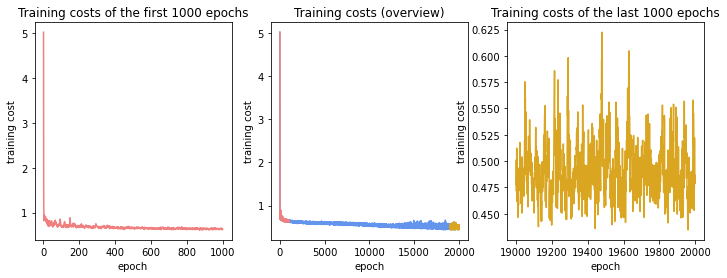

In [348]:
fig, ax = plt.subplots(1,3, figsize = (12,4))
ax[0].plot(range(1,len(cost_history)+1)[:1000], cost_history[:1000], color = "lightcoral")
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training cost')
ax[0].set_title('Training costs of the first 1000 epochs')
ax[1].plot(range(1,len(cost_history)+1), cost_history, color = "cornflowerblue")
ax[1].plot(range(1,len(cost_history)+1)[:1000], cost_history[:1000], color = "lightcoral")
ax[1].plot(range(1,len(cost_history)+1)[-1000:], cost_history[-1000:], color = "goldenrod")
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('training cost')
ax[1].set_title('Training costs (overview)')
ax[2].plot(range(1,len(cost_history)+1)[-1000:], cost_history[-1000:], color = "goldenrod")
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('training cost')
ax[2].set_title('Training costs of the last 1000 epochs')
plt.show()

In [349]:
train_acc = np.mean((predict(X[:2,:], model1, parameters)>0.5) == y)
test_acc = np.mean((predict(X_test.transpose()[:2,:], model1, parameters)>0.5) == y_test.reshape(1,-1))
print(f'Training set accuracy: {round(train_acc,3)} | Test set accuracy: {round(test_acc,3)}')

Training set accuracy: 0.843 | Test set accuracy: 0.824


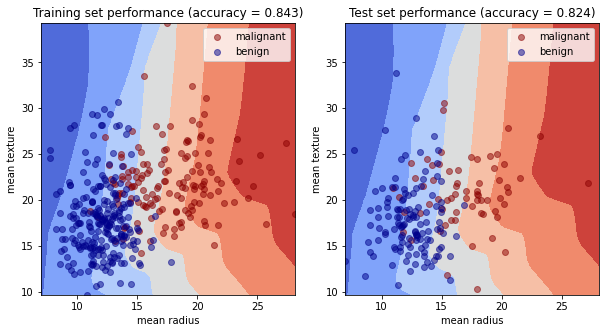

In [351]:
X1_min, X2_min = np.min(breast_cancer.data[:,:2], axis = 0)
X1_max, X2_max = np.max(breast_cancer.data[:,:2], axis = 0)
X1_span = np.linspace(X1_min, X1_max, 50)
X2_span = np.linspace(X2_min, X2_max, 50)
X1_space, X2_space = np.meshgrid(X1_span, X2_span)
#X_space = np.vstack((X_space[0].reshape(-1),X_space[1].reshape(-1))).transpose()
#leaves_space = tree1.apply(X_space)
#fit_space = tree1.predict(X_space)

fit_space = np.zeros(X1_space.shape)
d1, d2 = fit_space.shape
for i in range(d1):
    for j in range(d2):
        fit_space[i,j] = predict(np.array([[X1_space[i,j]],[X2_space[i,j]]]), model1, parameters)
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[0].scatter(X[0,y.reshape(-1)==0], X[1,y.reshape(-1)==0], color = 'darkred', label = target_names[0], alpha = 0.5)
ax[0].scatter(X[0,y.reshape(-1)==1], X[1,y.reshape(-1)==1], color = 'darkblue', label = target_names[1], alpha = 0.5)
ax[0].legend()
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title(f'Training set performance (accuracy = {round(train_acc,3)})')


ax[1].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[1].scatter(X_test.transpose()[0,y_test==0], X_test.transpose()[1,y_test.reshape(-1)==0], color = 'darkred', label = target_names[0], alpha = 0.5)
ax[1].scatter(X_test.transpose()[0,y_test==1], X_test.transpose()[1,y_test.reshape(-1)==1], color = 'darkblue', label = target_names[1], alpha = 0.5)
ax[1].legend()
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title(f'Test set performance (accuracy = {round(test_acc,3)})')

plt.show()